In [1]:
from scipy.integrate import odeint
import numpy as np
import scipy.constants as const
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import collections

In [7]:
Ic = 1e-6
Rsg = 10e3
Rn = Rsg
Cj = 2e-15
Rin = 100e0
Vgap = 4*Ic*Rn/np.pi #Gap voltage linked to IcRn, SIS relation
Vn = 1.1 #0.1*Vgap/Ic/Rin
V0 = Vn*Rin*Ic
phi0 = const.value('mag. flux quantum')
wp = 1/np.sqrt(Cj*phi0/2/np.pi/Ic)

params = {'Vn':Vn, 'Rsg': Rsg, 'Rn':Rn, 'Vgap':Vgap, 'Cj':Cj, 'Rin':Rin, 'wp':wp}
print(Vn)

1.1


In [8]:
taustop = 20* wp * Rsg*Cj
params['taustop'] = taustop
print(params)

{'Vn': 1.1, 'Vgap': 0.012732395447351628, 'taustop': 493.03427235163406, 'Cj': 2e-15, 'Rn': 10000.0, 'Rsg': 10000.0, 'wp': 1232585680879.0852, 'Rin': 100.0}


In [9]:
def Rj(V,params):
    Vgap = params['Vgap']
    if V>Vgap:
        return params['Rn']
    elif V<=Vgap:
        return params['Rsg']

def Q(V,params):
    Cj = params['Cj']
    Rin = params['Rin']
    wp = params['wp']
    return Cj*wp/(1/Rj(V,params)+1/Rin)

def Vs(t,params):
    if not hasattr(t,'__len__'):
        t = np.array([t])
    result = []
    for x in t:
        if x <params['taustop']/2:
            result.append(x/(params['taustop']/2)*params['Vn'])
        else:
            result.append(params['Vn'])
    #return params['Vn']
    result = np.ones(len(t))*params['Vn']
    return np.array(result)

def VJJmodel(z,t,params):
    f = z[0]
    g = z[1]
    V = phi0/2/np.pi*g
    fp = g
    gp = Vs(t,params)-(1/Q(V,params)*g+np.sin(f))
    return np.array([fp,gp])

In [10]:
ts = np.linspace(0,2*taustop,2000)
sols = odeint(VJJmodel,[0,0],ts, args=tuple([params]) )
solsfunc = interp1d(ts,sols.T)
Vjunc = lambda x: phi0/2/np.pi * wp * solsfunc(x)[1]
taurep = 2*np.pi/np.average(np.diff(sols[:,0])/np.diff(ts))

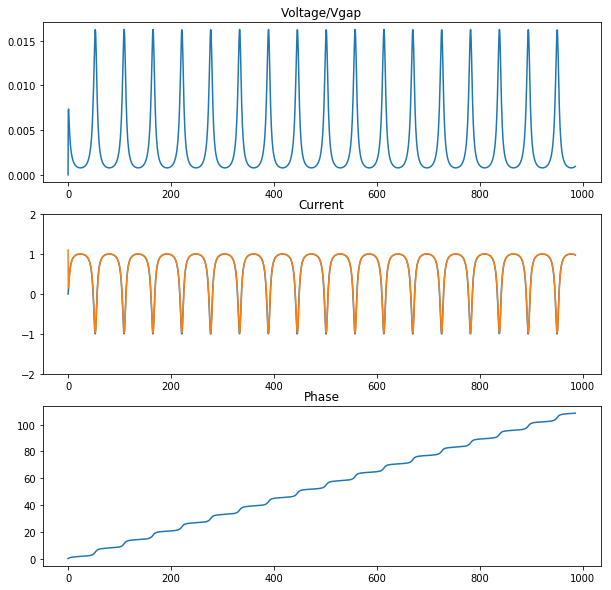

In [11]:
fig = plt.figure(figsize=(10,10))
plt.clf()
plt.subplot(3, 1, 1)
plt.title('Voltage/Vgap')
plt.plot(ts,Vjunc(ts) / Vgap)
plt.subplot(3, 1, 2)
plt.title('Current')
plt.plot(ts,np.sin(solsfunc(ts)[0]))
plt.plot(ts,(Vs(ts,params)*Ic*Rin-Vjunc(ts))/Rin/Ic)
plt.ylim([-2,2])
plt.subplot(3, 1, 3)
plt.title('Phase')
plt.plot(ts,solsfunc(ts)[0])
plt.show()
plt.close(fig)